# Instance Segmentation

Matheus Schmitz  
<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a>  
<a href="https://matheus-schmitz.github.io/">Github Portfolio</a>  

**Project Goal**  

The idea is to use a powerful pretained model (resnet), attaching new "prediction heads" to it, so that it can be trained on a labaled pedestrian dataset to perform both object detection (with Faster R-CNN) and instance segmentation (with Mask R-CNN).

Work is based on a tutorial provided by PyTorch: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

**Data Source**

[Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/)

## Environment Setup

In [25]:
# File manipulation imports for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Instance_Segmentation_Mask_RCNN")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!pip install -q watermark

In [27]:
# Imports
import os
import numpy as np
import watermark 

# Computer Vision
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import PIL

# Stop annoying warnings
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Track the package version user
%reload_ext watermark
%watermark --iversions

numpy      : 1.19.5
IPython    : 5.5.0
torch      : 1.8.1+cu101
torchvision: 0.9.1+cu101
watermark  : 2.2.0
PIL        : 7.1.2
google     : 2.0.3



In [29]:
# Configurate PyTorch to use GPu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [30]:
# Download the model evaluation toolkit from Torch Vision
!git clone https://github.com/pytorch/vision.git

fatal: destination path 'vision' already exists and is not an empty directory.


In [31]:
# Import toolkit tools to be used
!cp vision/references/detection/utils.py .
!cp vision/references/detection/transforms.py .
!cp vision/references/detection/coco_eval.py .
!cp vision/references/detection/engine.py .
!cp vision/references/detection/coco_utils.py .

## Load Data

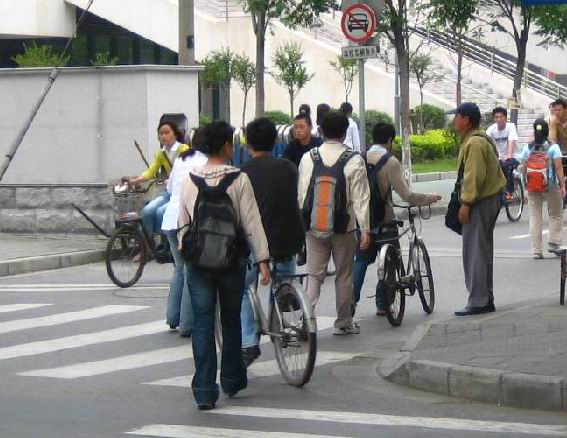

In [32]:
# View a sample image
PIL.Image.open('PennFudanPed/PNGImages/FudanPed00046.png')

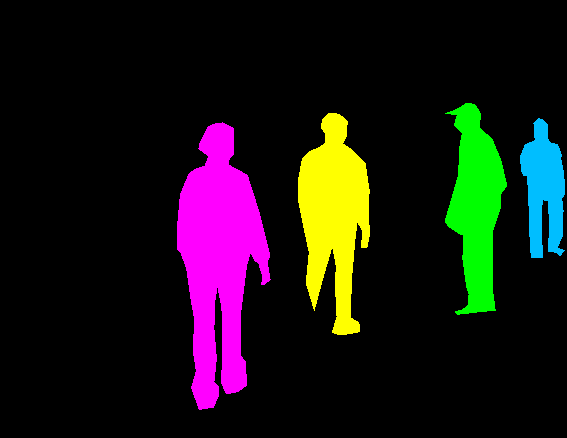

In [33]:
# View a sample mask
mask = PIL.Image.open('PennFudanPed/PedMasks/FudanPed00046_mask.png')

# Define the mask's color palette
mask.putpalette([0, 0, 0,     # First color is used for the background
                 255, 0, 255,   
                 255, 255, 0, 
                 0, 255, 0,
                 0, 190, 255,
                 255, 0, 0,
])

# View
mask

## Image Preprocessing

In [49]:
# Class to prepare the dataset
class PrepareDataset(torch.utils.data.Dataset):

    # Constructor
    def __init__(self, root, transforms = None):
        
        # Root folder with images and masks
        self.root = root
        
        # Image transformations to apply
        self.transforms = transforms
        
        # Load images and masks sorted by name to ensure alignment
        self.images = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
    # Method to feed items to the neural network
    def __getitem__(self, idx):
        
        # List of images and masks
        image_path = os.path.join(self.root, "PNGImages", self.images[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        # Load images to memory and convert colors (output is np.array)
        image = PIL.Image.open(image_path).convert("RGB")
        
        # Load masks to memory
        mask = PIL.Image.open(mask_path)
        
        # Convert masks from PIL to np.array
        mask = np.array(mask)
        
        # Instances are codified with different colors, hence each color = 1 instance
        obj_ids = np.unique(mask)
        
        # The first id is always for the image's background and can be removed
        obj_ids = obj_ids[1:]
        
        # Split the color coded masks into a set of binary masks
        masks = mask == obj_ids[:, None, None]
        
        # Get the bounding box coordinates for each mask
        num_pedestrians = len(obj_ids)
        boxes = []
        for i in range(num_pedestrians):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            
        # Convert the bounding boxes to tensors
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        
        # There is a single class (pedestria) per image, create labels for it
        labels = torch.ones((num_pedestrians,), dtype=torch.int64)
        
        # Convert masks to tensors
        masks = torch.as_tensor(masks, dtype = torch.uint8)
        
        # Convert ids to tensors
        image_id = torch.tensor([idx])
        
        # Calculate the total area for the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # Default to assuming images have no people in them
        iscrowd  = torch.zeros((num_pedestrians,), dtype = torch.int64)
        
        # Define the target variable
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        # Apply any specified image transformations
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        return image, target
    
    # Method to calculate dataset size
    def __len__(self):
        return len(self.images)

In [50]:
# Preprocess images to test the class created above
images = PrepareDataset('PennFudanPed/')

In [51]:
# View one item
images[46]

(<PIL.Image.Image image mode=RGB size=472x520 at 0x7FE840054FD0>,
 {'area': tensor([28116., 13688.,  5198.]),
  'boxes': tensor([[271., 197., 370., 481.],
          [ 30., 194.,  89., 426.],
          [383., 184., 429., 297.]]),
  'image_id': tensor([46]),
  'iscrowd': tensor([0, 0, 0]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  .

## Dataset Augmentation

In [52]:
# Imports
import utils
import transforms as T

In [53]:
def transform_images(isTrain):
    transforms = []
    transforms.append(T.ToTensor())
    if isTrain:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## Train Test Split

In [54]:
# Load and transform the train images
images = PrepareDataset('PennFudanPed/', 
                        transform_images(isTrain = True))

In [55]:
# Load test images without transforming
images = PrepareDataset('PennFudanPed/', 
                        transform_images(isTrain = False))

In [56]:
# Shuffle images
indexes = torch.randperm(len(images)).tolist()

In [57]:
# Select all but 50 images as training data
train_images = torch.utils.data.Subset(images, indexes[:-50])

# Then use the 50 leftover images for test
test_images = torch.utils.data.Subset(images, indexes[-50:])

In [58]:
# Create dataloaders for the images
train_data_loader = torch.utils.data.DataLoader(train_images,
                                                batch_size = 4,
                                                shuffle = True,
                                                num_workers = 0,
                                                collate_fn = utils.collate_fn)

test_data_loader = torch.utils.data.DataLoader(train_images,
                                                batch_size = 1,
                                                shuffle = False,
                                                num_workers = 0,
                                                collate_fn = utils.collate_fn)

## Build Model

In [59]:
# Imports
from engine import train_one_epoch, evaluate

In [60]:
# Function to build the model
def build_model():
    
    # There are only two classes: Pedestrian and Background
    num_classes = 2
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)
    
    # Get the number of input features used by bounding box classifier
    in_features_bbox = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the bounding box pretrained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features_bbox, num_classes)
    
    # Get the number of input features used by instance mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    
    # Replace the instance mask pretrained head with a new one
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    
    return model

In [61]:
# Run the function and build the model
model = build_model()

# Then send the model to the GPU
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [62]:
# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# Add a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

## Train Model

In [ ]:
num_epochs = 15

# Training loop
for epoch in range(num_epochs):
    
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, 
                    optimizer, 
                    train_data_loader, 
                    device, 
                    epoch, 
                    print_freq=10)
    
    # Update the learning rate
    lr_scheduler.step()
    
    # Evaluate on the test dataset
    evaluate(model, 
             test_data_loader, 
             device=device)

## Test Model

In [ ]:
# Set model to evaluation mode
model.eval()

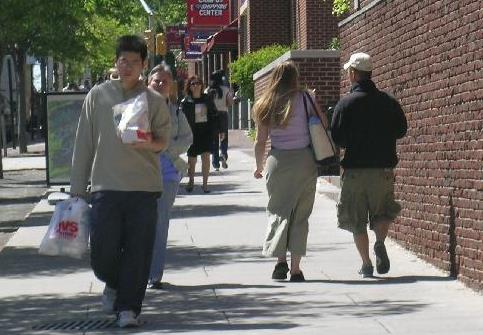

In [83]:
# Extract an image for testing
img1, _ = test_images[6]

# Original image
PIL.Image.fromarray(img1.mul(255).permute(1, 2, 0).byte().numpy())

In [84]:
# Predict on the test image
with torch.no_grad():
    predictions = model([img1.to(device)])

In [85]:
# Shape of the prediction mask
# The index 0 represents the number of maksks (pedestrians) found
predictions[0]['masks'].shape

torch.Size([7, 1, 335, 483])

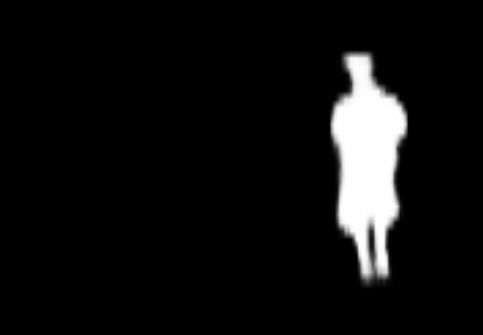

In [86]:
# Prediction 1
PIL.Image.fromarray(predictions[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

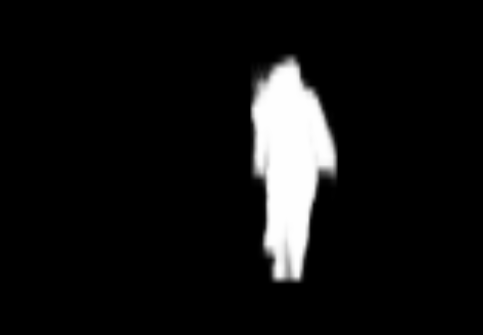

In [87]:
# Prediction 2
PIL.Image.fromarray(predictions[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

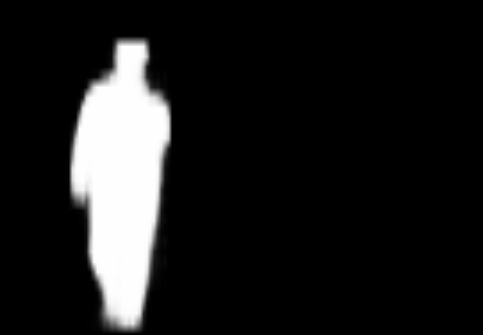

In [88]:
# Prediction 3
PIL.Image.fromarray(predictions[0]['masks'][2, 0].mul(255).byte().cpu().numpy())

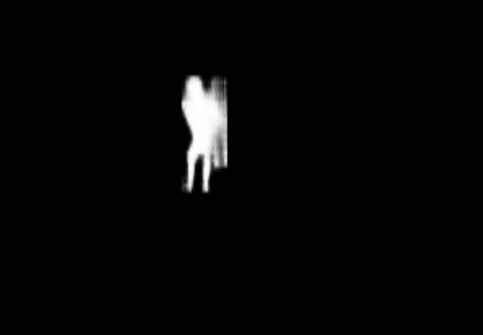

In [89]:
# Prediction 4
PIL.Image.fromarray(predictions[0]['masks'][3, 0].mul(255).byte().cpu().numpy())

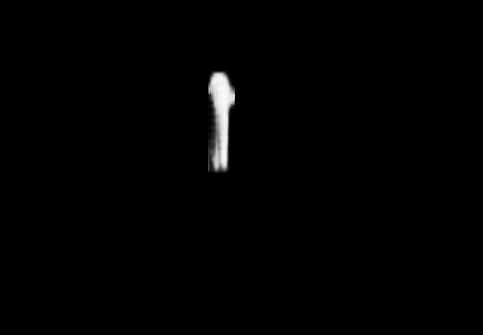

In [90]:
# Prediction 5
PIL.Image.fromarray(predictions[0]['masks'][4, 0].mul(255).byte().cpu().numpy())

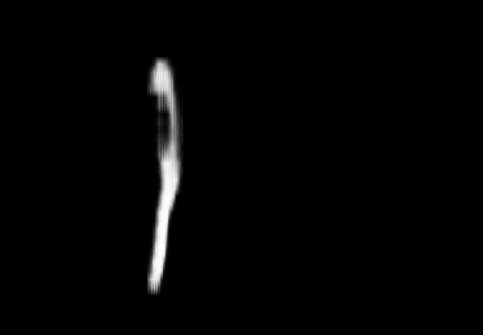

In [91]:
# Prediction 6
PIL.Image.fromarray(predictions[0]['masks'][5, 0].mul(255).byte().cpu().numpy())

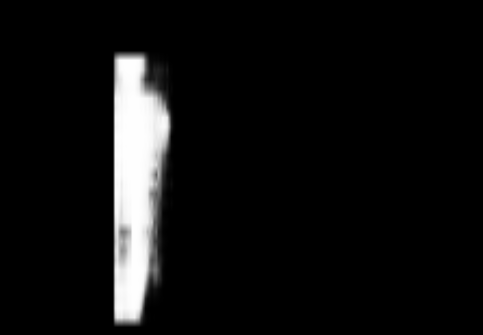

In [92]:
# Prediction 7
PIL.Image.fromarray(predictions[0]['masks'][6, 0].mul(255).byte().cpu().numpy())

In [93]:
# Prediction 8
PIL.Image.fromarray(predictions[0]['masks'][7, 0].mul(255).byte().cpu().numpy())

IndexError: ignored

# End
Matheus Schmitz  
<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a>  
<a href="https://matheus-schmitz.github.io/">Github Portfolio</a>  

In [96]:
!jupyter nbconvert --to html Instance_Segmentation_Mask_RCNN.ipynb

[NbConvertApp] WARNING | pattern u'Instance_Segmentation_Mask_RCNN.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'